In [1]:
import torch

import numpy as np
import time
import matplotlib.pyplot as plt

from buffer import ReplayBuffer
import gymnasium as gym        

device = torch.device('mps')

%load_ext autoreload
%autoreload 2

In [2]:
class channelFirst(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        gym.ObservationWrapper.__init__(self, env)
        
    def observation(self, observation):
        observation = (observation / 255) - 0.5
        return observation.transpose([2, 0, 1])

env = gym.make('ALE/Boxing-v5', render_mode="rgb_array")
env = gym.wrappers.ResizeObservation(env, shape=(64,64))
env = channelFirst(env)
obs, _ = env.reset()

action = env.action_space.sample()

def plot_obs(obs):
    obs = obs.transpose([1,2,0])
    plt.imshow(((obs + 0.5) * 255).astype(int))

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
encode = torch.load('./models/encoder', map_location=torch.device('cpu') )
decoder = torch.load('./models/decoder', map_location=torch.device('cpu') )
rssm = torch.load('./models/rssm_model', map_location=torch.device('cpu') )
actor = torch.load('./models/actor', map_location=torch.device('cpu'))

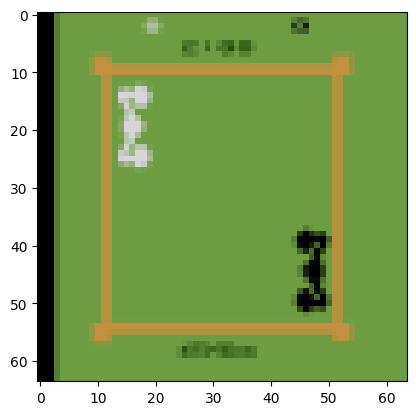

In [4]:
obs, _ = env.reset()
plot_obs(obs)

In [5]:
e_obs = encode(torch.from_numpy(obs).to(dtype=torch.float))
print(e_obs.shape)

torch.Size([1, 1024])


In [6]:
posterior = torch.zeros((1, 600))
deterministic = torch.zeros((1, 600))

_, posterior = rssm.representation(e_obs, deterministic)

In [7]:
from PIL import Image

frames = []

for i in range(50):
    actions= actor(posterior, deterministic)
    deterministic = rssm.recurrent(posterior, actions, deterministic)
    dist, posterior = rssm.transition(deterministic)
    d_obs = decoder(posterior, deterministic)
    d_obs = d_obs.mean.squeeze().detach().numpy()
    obs = ((d_obs.transpose([1,2,0]) + 0.5) * 255).astype(np.uint8)
    frames.append(Image.fromarray(obs, "RGB"))
    # plot_obs(d_obs)
    
frame_one = frames[0]
frame_one.save("./gif/imagine.gif", format="GIF", append_images=frames, save_all=True, duration=100, loop=0)